In [1]:
import os
import sys
import json
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from transformers import BertModel, BertTokenizer

w_dir = %pwd
work_dir = os.path.dirname(w_dir)
work_dir

I0327 03:43:57.595453 140481912182592 file_utils.py:39] PyTorch version 1.1.0 available.


'/work'

In [2]:
sys.path.append(w_dir+'/fgc_support_retri')

In [3]:
from fgc_support_retri.ser_extractor import *
from fgc_support_retri.utils import *
from fgc_support_retri import config
from evaluation.fgc_eval import *
from evaluation.eval import eval_sp_fgc, eval_fgc_atype

TabError: inconsistent use of tabs and spaces in indentation (bert_model.py, line 48)

In [ ]:
model_folder = config.TRAINED_MODELS / "old_etype" / "20200323_entity_lr=2e-5" 

In [4]:
extractor = Entity_extractor(model_folder)

NameError: name 'Entity_extractor' is not defined

In [36]:
eval_data = json_load(config.FGC_DEV)

In [37]:
get_answer_sp(eval_data, force=True)

100%|██████████| 247/247 [00:00<00:00, 32686.33it/s]


In [38]:
all_sp_predictions = []
all_atype_predictions = []
all_items = []
for d in tqdm(eval_data):
    for q in d['QUESTIONS']:
        sp_preds, _, sp_scores = extractor.predict(q, d)
        q['sp'] = sp_preds
        q['sp_scores'] = sp_scores

100%|██████████| 247/247 [04:37<00:00,  1.14s/it]


In [39]:
all_items, all_sp_predictions, all_answer_sp = eval_from_threshold(eval_data, threshold=0.5)

100%|██████████| 247/247 [00:00<00:00, 68018.72it/s]


In [40]:
metrics = eval_sp_fgc(all_items, all_sp_predictions)

{'sp_em': 0.172, 'sp_prec': 0.614, 'sp_recall': 0.625, 'sp_f1': 0.574}


In [41]:
metrics = eval_sp_fgc(all_answer_sp, all_sp_predictions)

{'sp_em': 0.155, 'sp_prec': 0.376, 'sp_recall': 0.591, 'sp_f1': 0.424}


# draw intervals

In [42]:
def get_interval_span():
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    return intervals

In [43]:
def get_interval(score):
    # get interval span
    intervals = []
    last = 0
    step = 10
    for i in range(step):
        now = round(last+1/step, 1)
        intervals.append((last, now))
        last = now
    
    # get interv_i
    for interv_i, interv in enumerate(intervals):
        if interv[0] <= score < interv[1]:
            return interv_i

In [44]:
def createLabels(data):
    all_height = 0
    for item in data:
        all_height += item.get_height()
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '{}% ({})'.format(int(height/all_height*100), int(height)),
            ha = "center",
            va = "bottom",
        )

In [45]:
intervals = get_interval_span()

In [46]:
interv_scores_p = [0] * 10
interv_scores_n = [0] * 10
interv_scores_answer = [0] * 10
interv_scores_not_answer = [0] * 10
for document in eval_data:
    for question in document['QUESTIONS']:
        if not question['SHINT']:
            continue
        for sent_i, sp_score in enumerate(question['sp_scores']):
            if sent_i in question['SHINT']:
                interv_scores_p[get_interval(sp_score)] += 1
                if sent_i in question['answer_sp']:
                    interv_scores_answer[get_interval(sp_score)] += 1
                else:
                    interv_scores_not_answer[get_interval(sp_score)] += 1
            else:
                interv_scores_n[get_interval(sp_score)] += 1

I0327 03:37:28.188687 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0327 03:37:28.190625 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'all sp')

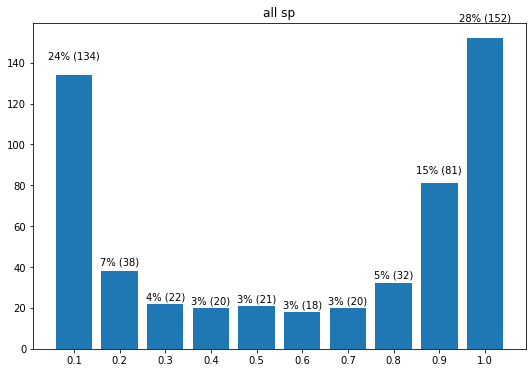

In [47]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
A = plt.bar([str(interv[1]) for interv in intervals], interv_scores_p)
createLabels(A)
plt.title('all sp')

I0327 03:37:28.547932 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0327 03:37:28.550042 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not sp')

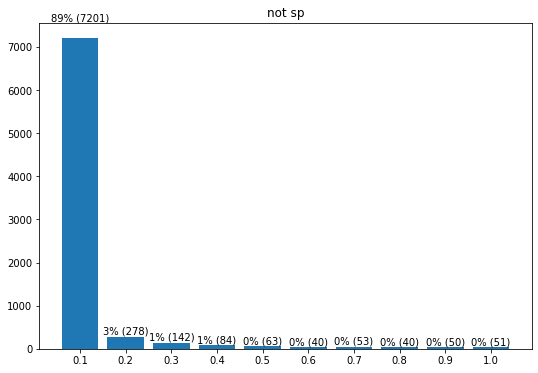

In [48]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_n)
createLabels(B)
plt.title('not sp')

I0327 03:37:28.886749 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0327 03:37:28.888634 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'answer sp')

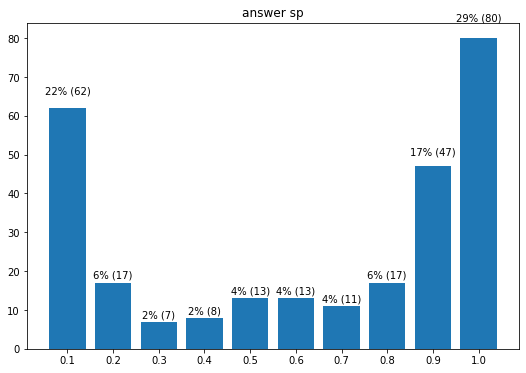

In [49]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_answer)
createLabels(B)
plt.title('answer sp')

I0327 03:37:29.218639 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0327 03:37:29.220345 140575910225728 category.py:225] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'not answer sp')

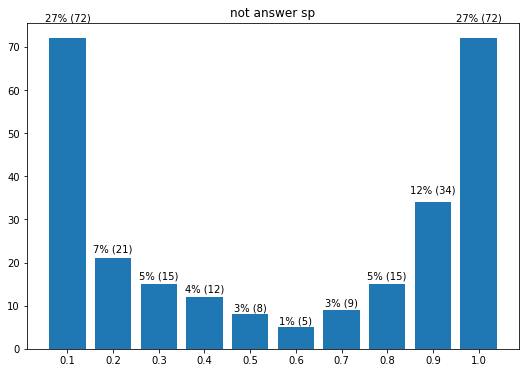

In [50]:
plt.figure(figsize=(30, 6))
plt.subplot(131)
B = plt.bar([str(interv[1]) for interv in intervals], interv_scores_not_answer)
createLabels(B)
plt.title('not answer sp')